In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
from replay_trajectory_classification.simulate import simulate_multiunit_with_place_fields
import numpy as np

radius = 30
angle = np.linspace(-np.pi, np.pi, num=10, endpoint=False)

place_field_means = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)
n_tetrodes = 5

position_angles = np.linspace(-np.pi, 31 * np.pi, num=100_000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)
sampling_frequency = 1000

multiunits = []
for place_means in place_field_means:
    multiunits.append(
        simulate_multiunit_with_place_fields(
            place_means[np.newaxis], position, mark_spacing=10,
            n_mark_dims=4,
            sampling_frequency=sampling_frequency))
    
multiunits = np.stack(multiunits, axis=-1)
multiunits_spikes = np.any(~np.isnan(multiunits), axis=1)

time = np.arange(position.shape[0]) / sampling_frequency

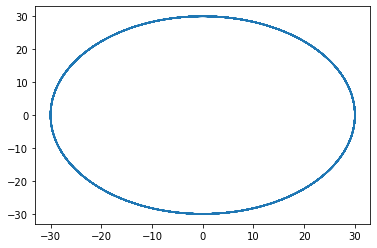

In [3]:
plt.plot(position[:, 0], position[:, 1])

In [4]:
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform
from replay_trajectory_classification import ClusterlessClassifier

environment = Environment(place_bin_size=2)
continuous_transition_types = (
    [[RandomWalk(movement_var=0.25, use_diffusion=True), Uniform()],
     [Uniform(),    Uniform()]])

clusterless_algorithm = 'multiunit_likelihood_integer_gpu'
clusterless_algorithm_params = {
    'mark_std': 1.0,
    'position_std': 12.5,
    'use_diffusion_distance': True,
}


decoder = ClusterlessClassifier(
    environments=[environment],
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params,
    continuous_transition_types=continuous_transition_types,
    
)

decoder.fit(position, multiunits)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


ClusterlessClassifier(clusterless_algorithm='multiunit_likelihood_integer_gpu',
                      clusterless_algorithm_params={'mark_std': 1.0,
                                                    'position_std': 12.5,
                                                    'use_diffusion_distance': True},
                      continuous_transition_types=[[RandomWalk(environment_name='', movement_var=0.25, movement_mean=0.0, use_diffusion=True),
                                                    Uniform(environment_name='', environment2_name=None)],
                                                   [Unif...
                      environments=[Environment(environment_name='', place_bin_size=2, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True)],
                      infer_track_interior=True,
                      initial_conditions_type=UniformInitialConditions(),
                      observation_models=(Ob

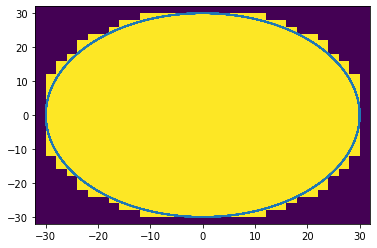

In [5]:
plt.pcolormesh(decoder.environments[0].edges_[0],
               decoder.environments[0].edges_[1],
               decoder.environments[0].is_track_interior_.T)
plt.plot(position[:, 0], position[:, 1])

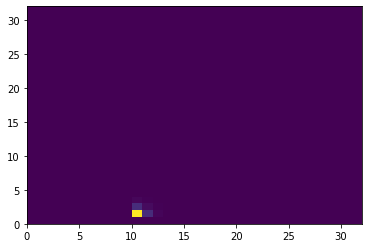

In [6]:
import matplotlib.pyplot as plt
plt.pcolormesh(
    decoder.continuous_state_transition_[0, 0][42].reshape(decoder.environments[0].centers_shape_, order='F').T)

In [7]:
time_ind = slice(0, 50_000)
results = decoder.predict(multiunits[time_ind], time=time[time_ind], use_gpu=True)

results

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, state: 2, x_position: 32, y_position: 32)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * x_position         (x_position) float64 -31.0 -29.0 -27.0 ... 27.0 29.0 31.0
  * y_position         (y_position) float64 -31.0 -29.0 -27.0 ... 27.0 29.0 31.0
  * state              (state) object RandomWalk(environment_name='', movemen...
Data variables:
    likelihood         (time, state, x_position, y_position) float32 nan ... nan
    causal_posterior   (time, state, x_position, y_position) float32 nan ... nan
    acausal_posterior  (time, state, x_position, y_position) float32 nan ... nan
Attributes:
    data_log_likelihood:  -2124.8394

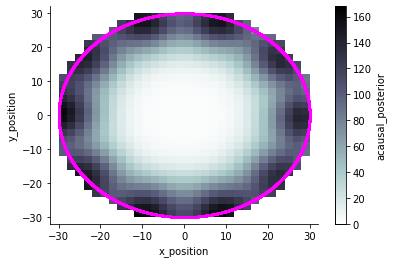

In [8]:
import seaborn as sns

results.acausal_posterior.sum(['time', 'state']).plot(x='x_position', y='y_position', cmap='bone_r')
plt.scatter(position[time_ind, 0], position[time_ind, 1], color='magenta', s=1, clip_on=False, label='True Position')
sns.despine()

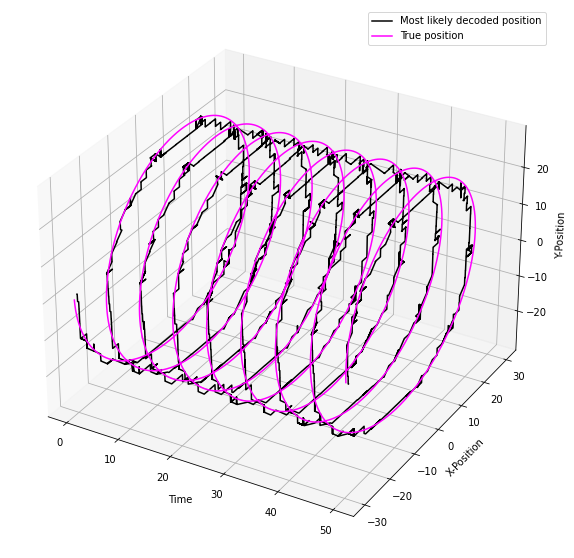

In [9]:
map_estimate = results.acausal_posterior.sum('state').stack(position=['x_position', 'y_position'])
map_estimate = map_estimate.position[map_estimate.argmax('position')]
map_estimate = np.asarray(map_estimate.values.tolist())

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot3D(results.time, map_estimate[:, 0], map_estimate[:, 1], 'black', label='Most likely decoded position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')

ax.plot3D(results.time, position[time_ind, 0], position[time_ind, 1], 'magenta', label='True position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')
plt.legend()